In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from PIL import Image
from torchvision import transforms
# from transformers import AutoModelForImageClassification, AutoTokenizer
from dlsia.core.networks import tunet

/Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <650A7408-F84B-37A3-B9D0-8E799E9E0543> /Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
output_directory = "../data/output/images_given_with_model"
os.makedirs(output_directory, exist_ok=True)

hyperparams_path = "../dlsia_inpainting_saxs_gisaxs/network_hyperparameters.npy"

# Attempt to load the file with allowing pickle
try:
    hyperparams = np.load(hyperparams_path, allow_pickle=True).item()
    print("Hyperparameters loaded successfully:")
    print(hyperparams)
except Exception as e:
    print(f"Failed to load hyperparameters with np.load: {e}")

    # Attempt to read the file content as text
    try:
        with open(hyperparams_path, 'r') as f:
            content = f.read()
            print("File content:")
            print(content)
    except Exception as e:
        print(f"Failed to read file content: {e}")

Hyperparameters loaded successfully:
{'in_channels': 1, 'out_channels': 1, 'num_layers': 200, 'layer_width': 1, 'max_dilation': 15, 'activation': ReLU(), 'final_layer': None, 'convolution': <class 'torch.nn.modules.conv.Conv2d'>, 'normalization': None}


In [4]:
import torch.nn as nn

# Define a simple sequential model to test basic functionality
try:
    simple_model = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 1, kernel_size=3, padding=1)
    )
    print("Simple model initialized successfully.")
except Exception as e:
    print(f"Failed to initialize simple model: {e}")
    raise

Simple model initialized successfully.


In [5]:
input_directory = "../data/input/LBNL_ALS_Scattering_data_jpg"

# Define image transformations
def safe_divide(x):
    max_val = x.max()
    if max_val > 0:
        return x / max_val
    else:
        return x

def safe_log1p(x):
    return torch.log1p(torch.clamp(x, min=0))

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(safe_divide),
    transforms.Lambda(safe_log1p)
])

# Process each image in the directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.jpg', '.jpeg', '.tiff', '.png')):
        image_path = os.path.join(input_directory, filename)

        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

            input_image_np = np.array(image)  # Original input image as a NumPy array
            print(f"Image: {filename}")
            print(f"Dimensions: {input_image_np.shape}")
            print(f"Data type: {input_image_np.dtype}")
            print(f"Min intensity: {input_image_np.min()}")
            print(f"Max intensity: {input_image_np.max()}")
            print(f"Mean intensity: {input_image_np.mean()}")
            print()
            input_min, input_max = input_image_np.min(), input_image_np.max()  # Get original intensity range
            
            print(f"Loaded and preprocessed image: {filename}")
            break
        except Exception as e:
            print(f"Failed to load or preprocess image {filename}: {e}")
            continue

Image: 00000038.jpg
Dimensions: (1679, 1475)
Data type: uint8
Min intensity: 4
Max intensity: 255
Mean intensity: 135.78286389194537

Loaded and preprocessed image: 00000038.jpg


Model loaded and set to evaluation mode successfully.
Input images loaded successfully with shape: (5, 1, 512, 512)
Converted images to tensor with shape: torch.Size([5, 1, 512, 512])
Processed image 1/5


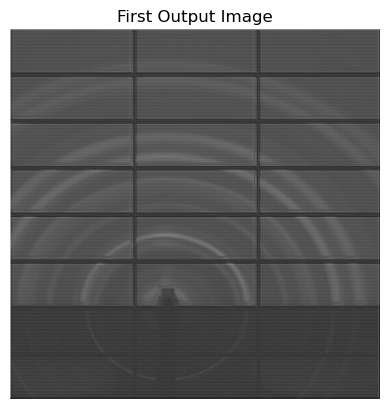

Saved image 1/5 to ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted
Processed image 2/5
Saved image 2/5 to ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted
Processed image 3/5
Saved image 3/5 to ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted
Processed image 4/5
Saved image 4/5 to ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted
Processed image 5/5
Saved image 5/5 to ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted
Processing complete. Output images saved.
TUNet(
  (activation): ReLU()
  (Encode_0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Decode_0): Sequential(
    (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [100]:
### Running out of RAM when I try to run it - 10 layers max on my computer###

# Initialize the TUNet model using hyperparameters
tunet_model = tunet.TUNet(
    image_shape=(512, 512),  # Assuming a default image shape, adjust if needed
    in_channels=hyperparams['in_channels'],
    out_channels=hyperparams['out_channels'],
    base_channels=hyperparams.get('base_channels', 4),  # Default to 4 if not specified
    depth=10, # hyperparams.get('num_layers', 3),  # Default to 3 if not specified
    growth_rate=hyperparams.get('growth_rate', 1.5)  # Default to 1.5 if not specified
)



# Load the model weights from the binary file
model_path = "../dlsia_inpainting_saxs_gisaxs/net"
try:
    tunet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
    tunet_model.eval()
    print("Model loaded and set to evaluation mode successfully.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the input images
input_images_path = "../dlsia_inpainting_saxs_gisaxs/imgs_to_segment.npy"
try:
    input_images = np.load(input_images_path, allow_pickle=True)
    print(f"Input images loaded successfully with shape: {input_images.shape}")
except Exception as e:
    print(f"Failed to load input images: {e}")
    raise

# Convert the numpy array to a PyTorch tensor
preprocessed_images = torch.tensor(input_images, dtype=torch.float32)
print(f"Converted images to tensor with shape: {preprocessed_images.shape}")

# Add batch dimension if necessary
if preprocessed_images.ndim == 3:
    preprocessed_images = preprocessed_images.unsqueeze(0)
    print(f"Added batch dimension, new shape: {preprocessed_images.shape}")

# Process the input images through the model one by one to reduce memory usage
for i in range(preprocessed_images.size(0)):
    single_image = preprocessed_images[i].unsqueeze(0)  # Add batch dimension

    try:
        with torch.no_grad():
            output_image = tunet_model(single_image)
        print(f"Processed image {i+1}/{preprocessed_images.size(0)}")
    except Exception as e:
        print(f"Failed to process image {i+1}/{preprocessed_images.size(0)}: {e}")
        continue

    # Post-process and display the first image
    try:
        output_image = output_image.squeeze().cpu().numpy()
        output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())  # Normalize to [0, 1]
        output_image = (output_image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        
        # Convert to PIL Image
        pil_image = Image.fromarray(output_image)
        
        # Display the first image
        if i == 0:
            plt.imshow(pil_image, cmap='gray')
            plt.title('First Output Image')
            plt.axis('off')
            plt.show()
        
        # Save the image
        pil_image.save(os.path.join(output_directory, f"output_{i}.png"))
        print(f"Saved image {i+1}/{preprocessed_images.size(0)} to {output_directory}")

    except Exception as e:
        print(f"Failed to post-process or save image {i+1}/{preprocessed_images.size(0)}: {e}")

print("Processing complete. Output images saved.")

print(tunet_model)

In [48]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Ensure you have the tunet module imported
# import tunet  # Uncomment if tunet is a module you have

# Initialize the TUNet model using hyperparameters
tunet_model = tunet.TUNet(
    image_shape=(512, 512),
    in_channels=hyperparams['in_channels'],
    out_channels=hyperparams['out_channels'],
    base_channels=hyperparams.get('base_channels', 4),
    depth= 10, # hyperparams['depth'],
    growth_rate=hyperparams.get('growth_rate', 1.5)
)

# Load the model weights from the binary file
model_path = "../dlsia_inpainting_saxs_gisaxs/net"
tunet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
tunet_model.eval()
print("Model loaded and set to evaluation mode successfully.")

# Directory of input images
input_directory = "../data/input/LBNL_ALS_Scattering_data_jpg"

# Directory to save the output images
output_directory = "../data/output/LBNL_ALS_Scattering_data_jpg_inpainted"
os.makedirs(output_directory, exist_ok=True)

# Define image transformations
def safe_divide(x):
    max_val = x.max()
    if max_val > 0:
        return x / max_val
    else:
        return x

def safe_log1p(x):
    return torch.log1p(torch.clamp(x, min=0))

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(safe_divide),
    transforms.Lambda(safe_log1p)
])

# Process each image in the directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.jpg', '.jpeg', '.tiff', '.png')):
        image_path = os.path.join(input_directory, filename)
        output_path = os.path.join(output_directory, filename)

        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

            input_image_np = np.array(image)  # Original input image as a NumPy array
            input_min, input_max = input_image_np.min(), input_image_np.max()  # Get original intensity range
            
            print(f"Loaded and preprocessed image: {filename}")
        except Exception as e:
            print(f"Failed to load or preprocess image {filename}: {e}")
            continue
        

        # Run the model
        try:
            with torch.no_grad():
                output_tensor = tunet_model(input_tensor)
            print(f"Processed image: {filename}")
        except Exception as e:
            print(f"Failed to process image {filename}: {e}")
            continue
        
        # Post-process and save the output
        try:
            # output_image = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
            # # Normalize output_image to [0, 255]
            # output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())
            
            # contrast_factor = 1.5  # Adjust this value as needed
            # output_image = np.clip((output_image - 0.5) * contrast_factor + 0.5, 0, 1)
            
            # output_image = (output_image * 255).astype(np.uint8)

            output_image = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
            # Normalize the output image to [0, 1]
            output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())
            # Scale the output image back to the original intensity range
            output_image = output_image * (input_max - input_min) + input_min
            output_image = np.clip(output_image, 0, 255).astype(np.uint8)

            # Convert to PIL Image and save
            output_pil_image = Image.fromarray(output_image)
            output_pil_image.save(output_path)
            print(f"Saved output image: {output_path}")
        except Exception as e:
            print(f"Failed to post-process or save image {filename}: {e}")
            continue
        break

print("Processing complete. Output images saved.")


Model loaded and set to evaluation mode successfully.
Loaded and preprocessed image: 00000038.jpg
Processed image: 00000038.jpg
Saved output image: ../data/output/LBNL_ALS_Scattering_data_jpg_inpainted/00000038.jpg
Processing complete. Output images saved.
